# Time-series Forecasting

## Imports

In [1]:
import os

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from window_generator_tf import WindowGenerator

from typing import List, Optional
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
packetLossRate = np.random.random((300,))
jitter = np.arange(300)
latency = np.random.random((300,))

In [3]:
from datetime import datetime, timedelta

current = datetime.now()
times = [(current + timedelta(seconds=(i + i % 60 / 60))).strftime("%Y-%m-%d %H:%M:%S.%f") for i in range(300)]

In [4]:
df = pd.DataFrame({
    'packetLossRate': packetLossRate,
    'jitter': jitter,
    'latency': latency,
    'timestamp': times
})
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [5]:
train_df = df[:100]
val_df = df[100:200]
test_df = df[200:]

In [6]:
s1 = WindowGenerator(20, 5, 2, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['packetLossRate', 'jitter'])
s1

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Label indices: [22 23 24 25 26]
Input column name(s): Index(['packetLossRate', 'jitter', 'latency'], dtype='object')
Label column name(s): ['packetLossRate', 'jitter']

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((20, 3)),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dense(2),
    tf.keras.layers.Cropping1D(cropping=(15, 0))
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 128)           67584     
                                                                 


2022-03-24 23:39:27.532723: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-03-24 23:39:27.533395: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-03-24 23:39:27.534198: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 dense (Dense)               (None, 20, 2)             258       
                                                                 
 cropping1d (Cropping1D)     (None, 5, 2)              0         
                                                                 
Total params: 67,842
Trainable params: 67,842
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(loss='mse', optimizer='adam')

In [9]:
train_data = s1.train()
train_data

<MapDataset element_spec=(TensorSpec(shape=(None, 20, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 5, 2), dtype=tf.float64, name=None))>

In [10]:
model.fit(train_data, epochs=20)

Epoch 1/20
3/3 [==============================] - 1s 11ms/step - loss: 0.8946
Epoch 2/20
3/3 [==============================] - 0s 9ms/step - loss: 0.7324
Epoch 3/20
3/3 [==============================] - 0s 8ms/step - loss: 0.6085
Epoch 4/20
3/3 [==============================] - 0s 8ms/step - loss: 0.5308
Epoch 5/20
3/3 [==============================] - 0s 8ms/step - loss: 0.5249
Epoch 6/20
3/3 [==============================] - 0s 8ms/step - loss: 0.5094
Epoch 7/20
3/3 [==============================] - 0s 9ms/step - loss: 0.4932
Epoch 8/20
3/3 [==============================] - 0s 9ms/step - loss: 0.4919
Epoch 9/20
3/3 [==============================] - 0s 9ms/step - loss: 0.4886
Epoch 10/20
3/3 [==============================] - 0s 9ms/step - loss: 0.4842
Epoch 11/20
3/3 [==============================] - 0s 9ms/step - loss: 0.4813
Epoch 12/20
3/3 [==============================] - 0s 9ms/step - loss: 0.4766
Epoch 13/20
3/3 [==============================] - 0s 9ms/step - loss: 0

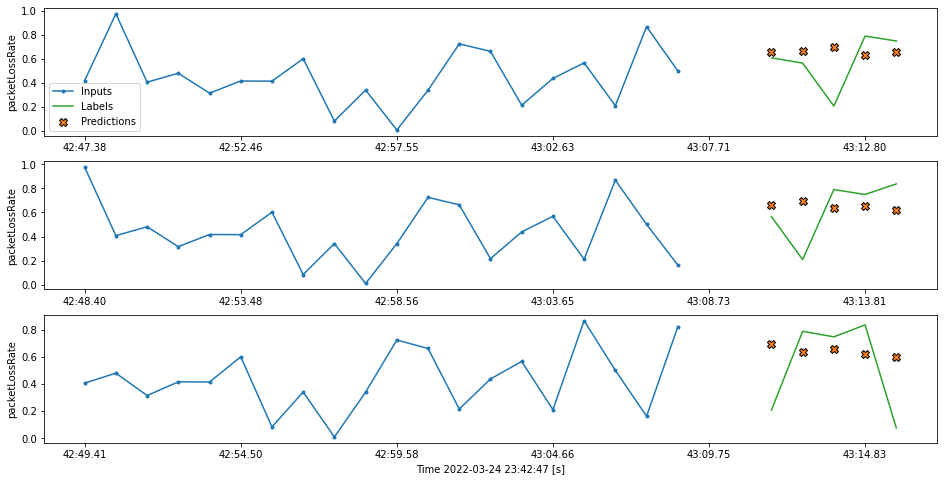

In [13]:
s1.plot(model, plot_col='packetLossRate')

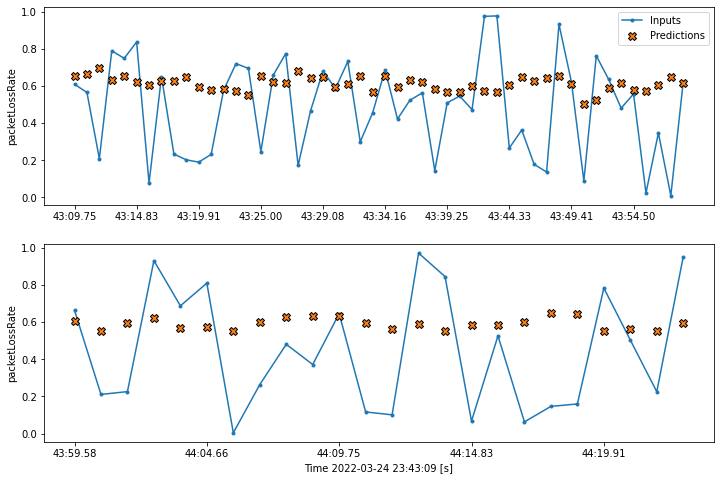

In [17]:
s1.plot_y(model, plot_col='packetLossRate', max_subplots=2)